# Prediction of bulldozer prices

1. Problem defition
>How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

2. Data
>The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

3. Evaluation
> Per Kaggle the evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

4. Features
> Kaggle provides a data dictionary detailing all of the features of the dataset. 

In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

%matplotlibline

UsageError: Line magic function `%matplotlibline` not found.


In [244]:
#import data
df=pd.read_csv('data/TrainAndValid.csv',
              low_memory=False)

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [246]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

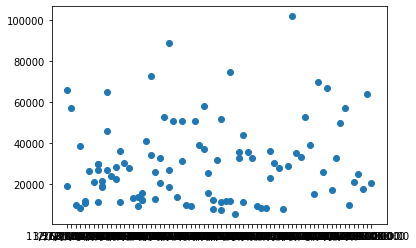

In [247]:
fig,ax= plt.subplots()
ax.scatter(df['saledate'][:100],df['SalePrice'][:100]);
#plot just first 100 obs of sale date and sale price

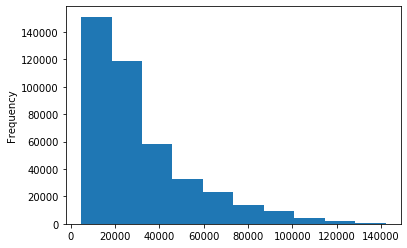

In [248]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data we want them as date time object

We can tell Pandas which columns has dates and use `parsing_dates` parameter

In [249]:
#import date again but this time parse dates
df=pd.read_csv('data/TrainAndValid.csv',
              low_memory=False,
              parse_dates=['saledate'])

In [250]:
df.saledate.dtype #<M8[ns] is datetime64[ns] both same

dtype('<M8[ns]')

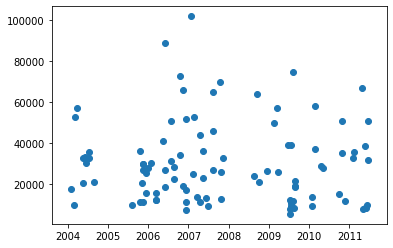

In [251]:
# plot again and this time the date axis will not be congested
fig,ax= plt.subplots()
ax.scatter(df['saledate'][:100],df['SalePrice'][:100]);

In [252]:
#to see all columns in one view , transpose
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort df by saledate

In [253]:
# Sort df in date order for training data
df.sort_values(by=['saledate'],inplace=True,ascending=True)
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [254]:
# Make a copy of df, we want to keep original
df_tmp=df.copy()

### Feature Engineering

Add datetime parameter for `saledate` column

In [255]:
df_tmp['saleYear']=df_tmp.saledate.dt.year
df_tmp['saleMonth']=df_tmp.saledate.dt.month
df_tmp['saleDay']=df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek']=df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear']=df_tmp.saledate.dt.dayofyear

df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [256]:
# remove saledate column
df_tmp= df_tmp.drop('saledate',axis=1)

#Split into train and validation dataset
df_train=df_tmp[df_tmp.saleYear!= 2012]
df_val=df_tmp[df_tmp.saleYear == 2012]

df_val.shape,df_train.shape

((11573, 57), (401125, 57))

In [258]:
# check different number of values of different columns
df_val.saleYear.value_counts()

2012    11573
Name: saleYear, dtype: int64

### Convert strings into categories

In [259]:
# Find columns which are strings
for label, content in df_train.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

#for validation set
for label, content in df_val.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
#label = column, content =values

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls
UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriag

In [260]:
# turn string value to category
for label, content in df_train.items():
    if pd.api.types.is_string_dtype(content):
        df_train[label]=content.astype('category').cat.as_ordered()
# turns object to category, meaning pandas will change string value
#to numeric value under the hood

#For validation set
for label, content in df_val.items():
    if pd.api.types.is_string_dtype(content):
        df_val[label]=content.astype('category').cat.as_ordered()

<ipython-input-260-12537b7d9755>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[label]=content.astype('category').cat.as_ordered()
<ipython-input-260-12537b7d9755>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val[label]=content.astype('category').cat.as_ordered()


In [261]:
df_val.shape,df_train.shape

((11573, 57), (401125, 57))

In [262]:
# to check what numeric value it gives under the hood
df_train.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
393098    31
400217    31
400302    31
400393    31
393123    31
Length: 401125, dtype: int8

### Handle missing value

In [263]:
# find percent of missing data
df_train.isnull().sum()/len(df_train)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.050199
YearMade                    0.000000
MachineHoursCurrentMeter    0.644089
UsageBand                   0.826391
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.342016
fiModelSeries               0.858129
fiModelDescriptor           0.820707
ProductSize                 0.525460
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.739829
Enclosure                   0.000810
Forks                       0.521154
Pad_Type                    0.802720
Ride_Control                0.629527
Stick                       0.802720
Transmission                0.543210
Turbocharged                0.802720
B

### Save preprocessed data into csv

In [264]:
# Export 
df_train.to_csv('data/train_tmp.csv', index=False)
df_val.to_csv('data/val_tmp.csv', index=False)

In [265]:
#import
df_train=pd.read_csv('data/train_tmp.csv',low_memory=False)
df_val=pd.read_csv('data/val_tmp.csv',low_memory=False)

df_val.shape,df_train.shape

((11573, 57), (401125, 57))

### Handle missing values


#### Fill numerical missing values first

In [266]:
# Find numberic type columns
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [267]:
# Check for which numeric columns has missing values
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [268]:
# Fill numeric rows with median
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #add a binary column which tells us if data was missing or not
            df_train[label+'_is_missing']=pd.isnull(content)
            #fill missing numeric values with median
            df_train[label]=content.fillna(content.median())
# we use median bcz median is more robust and we do not want outliers to affect

#for validaton set
for label, content in df_val.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #add a binary column which tells us if data was missing or not
            df_val[label+'_is_missing']=pd.isnull(content)
            #fill missing numeric values with median
            df_val[label]=content.fillna(content.median())

In [269]:
df_val.shape,df_train.shape
#in validation set 'auctioneerID_is_missing' is missing bcz there was no null

((11573, 58), (401125, 59))

In [270]:
#df_train[auctioneerID_is_missing].head()
df_train.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleDay', 'saleDayOfWeek', 'saleDayOfYear', 'auctioneerI

In [271]:
df_val['auctioneerID_is_missing']=False
df_val['auctioneerID_is_missing'].head()

0    False
1    False
2    False
3    False
4    False
Name: auctioneerID_is_missing, dtype: bool

In [272]:
df_val.shape,df_train.shape

((11573, 59), (401125, 59))

In [273]:
df_val.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleDay', 'saleDayOfWeek', 'saleDayOfYear',
       'Mach

In [274]:
df_train.columns
#the order is mismatched

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleDay', 'saleDayOfWeek', 'saleDayOfYear', 'auctioneerI

In [275]:
#fix the order
df_val=df_val[['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleDay', 'saleDayOfWeek', 'saleDayOfYear', 'auctioneerID_is_missing',
       'MachineHoursCurrentMeter_is_missing']]

In [276]:
#check the order same or not
df_val.columns==df_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [277]:
# Check if any numeric columns has missing values left
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            print(label)

### Fill categorical missing values

In [278]:
# Check if any categorical columns has missing values left
for label, content in df_train.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            print(label)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [279]:
# Check if any categorical columns has missing values left in validation set
for label, content in df_val.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            print(label)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [280]:
# Fill categorical variables missing rows with number '0'
# Right now for categorical variables , missing rows are coded as -1
# we want it to be '0' so we know that row had missing values
for label, content in df_train.items():
    if not pd.api.types.is_numeric_dtype(content):
        #add a binary column which tells us if data was missing or not
        df_train[label+'_is_missing']=pd.isnull(content)
        #fill missing numeric values with median
        df_train[label]=pd.Categorical(content).codes + 1 #this will change to 0
        
# For validation set
for label, content in df_val.items():
    if not pd.api.types.is_numeric_dtype(content):
        #add a binary column which tells us if data was missing or not
        df_val[label+'_is_missing']=pd.isnull(content)
        #fill missing numeric values with median
        df_val[label]=pd.Categorical(content).codes + 1

In [282]:
df_val.shape,df_train.shape


((11573, 103), (401125, 103))

In [283]:
# Split into X y train, X y test dataset
X_train,y_train=df_train.drop('SalePrice',axis=1),df_train.SalePrice
X_valid,y_valid=df_val.drop('SalePrice',axis=1),df_val.SalePrice

X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Build the evaluation function RMSLE

Since evaluation is based on RMSLE, and it doesnt exists in sklearn we need to build it

In [284]:
#Create RMSLE
from sklearn.metrics import mean_squared_log_error,mean_absolute_error,r2_score

def rmsle(y_test,y_pred):
    return np.sqrt(mean_squared_log_error(y_test,y_pred))

#Create function to evaluate model on few other levels
def show_scores(model):
    train_pred=model.predict(X_train)
    val_pred=model.predict(X_valid)
    scores={'Training MAE':mean_absolute_error(y_train,train_pred),
           'Valid MAE':mean_absolute_error(y_valid,val_pred),
           'Training RMSLE':rmsle(y_train,train_pred),
           'Valid RMSLE':rmsle(y_valid,val_pred),
           'Training R^2':r2_score(y_train,train_pred),
           'Valid R^2':r2_score(y_valid,val_pred)}
    return scores

# 5. Modeling

## Testing our model on a subset /max sample to tune hyperparameter

Because trying to tune hyperparamter everytime on 400k+ obs takes a lot of time

In [300]:
# Start with RandomForest
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_jobs=-1,
                           random_state=42,
                           max_samples=10000)

In [286]:
%time
#smaller number of sample will help cut down time
model.fit(X_train,y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [287]:
show_scores(model)

{'Training MAE': 5561.286907148645,
 'Valid MAE': 9792.934450877043,
 'Training RMSLE': 0.2577478749317532,
 'Valid RMSLE': 0.3901355992372278,
 'Training R^2': 0.8606644092878912,
 'Valid R^2': 0.661834841571406}

#### HYperparameter tuning with RandomizedSearchCV

In [288]:
%%time
from sklearn.model_selection import RandomizedSearchCV

#Define the hyperparameter grid
rf_grid={'n_estimators':np.arange(10,100,10),
        'max_depth':[None,3,5,10],
        'min_samples_split':np.arange(2,20,2),
        'min_samples_leaf':np.arange(1,20,2),
        'max_features':[0.5,1,'sqrt','auto'],
        'max_samples':[10000]}

#Instanstiate RandomizedSearchCV model
rs_model=RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                 random_state=42),
                           param_distributions=rf_grid,
                           n_iter=5,
                           cv=5,
                           verbose=True)

rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.5min finished


CPU times: user 58.2 s, sys: 10.3 s, total: 1min 8s
Wall time: 1min 33s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [289]:
rs_model.best_params_

{'n_estimators': 10,
 'min_samples_split': 8,
 'min_samples_leaf': 9,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [290]:
show_scores(rs_model)

{'Training MAE': 6736.484728801998,
 'Valid MAE': 10451.972669688606,
 'Training RMSLE': 0.3004300946192882,
 'Valid RMSLE': 0.4155381953290997,
 'Training R^2': 0.8017467242526286,
 'Valid R^2': 0.6299554834372119}

In [303]:
%%time

#most ideal hyperparameters
ideal_model=RandomForestRegressor(n_estimators=10,
                                 min_samples_leaf=9,
                                 min_samples_split=8,
                                 max_features='auto',
                                 n_jobs=-1,
                                 max_samples=None,
                                 random_state=42)

ideal_model.fit(X_train,y_train)

CPU times: user 2min 8s, sys: 774 ms, total: 2min 8s
Wall time: 14.8 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=9,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [305]:
%%time

#Zero-mastery most ideal model
# Most ideal hyperparamters applying FE without splitting train and validation set
master_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
master_model.fit(X_train, y_train)

CPU times: user 5min 14s, sys: 1.8 s, total: 5min 16s
Wall time: 32.1 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

# Make Predictions on TEST data

In [294]:
#import test data

df_test=pd.read_csv('data/test.csv',
                   low_memory=False,
                   parse_dates=['saledate'])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [295]:
#preprocess data to test dataset

def preprocess_data(df):
    #repeat all the manipulation we did to test datset before
    df['saleYear']=df.saledate.dt.year
    df['saleMonth']=df.saledate.dt.month
    df['saleDay']=df.saledate.dt.day
    df['saleDayOfWeek']=df.saledate.dt.dayofweek
    df['saleDayOfYear']=df.saledate.dt.dayofyear
    
    df.drop('saledate',axis=1,inplace=True)
    
    #Fill the numeric rows with median
    for label,content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                #add a binary column which tells us if data was missing
                df[label+'_is_missing']=pd.isnull(content)
                #Fill missing numeric values with median
                df[label]=content.fillna(content.median())
                
        #Fill categorical missing data by adding +1
        if not pd.api.types.is_numeric_dtype(content):
            df[label+'_is_missing']=pd.isnull(content)
            #we add +1 to category code to make -1 to 0. 0=missing values
            df[label]=pd.Categorical(content).codes+1
            
    return df

In [296]:
#Process the test data 
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [297]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [298]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [306]:
# Make predictions on the test data using ideal_model
test_pred = ideal_model.predict(df_test)
test_pred

#Using master_model
test_pred_master=master_model.predict(df_test)

In [309]:
# Format predictions into the same format Kaggle is after
df_pred = pd.DataFrame()
df_pred["SalesID"] = df_test["SalesID"]
df_pred["SalesPrice"] = test_pred
df_pred

#format for master model predictions
df_master_pred=pd.DataFrame()
df_master_pred["SalesID"] = df_test["SalesID"]
df_master_pred["SalesPrice"] = test_pred_master

In [310]:
# Export prediction data
df_pred.to_csv("data/test_predictions.csv", index=False)

df_master_pred.to_csv("data/test_predictions_master.csv", index=False)

# Feature Importance

In [311]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([4.44995112e-02, 9.46064015e-03, 3.29005642e-02, 7.36614908e-05,
       1.98775937e-03, 2.77651902e-01, 1.66587885e-03, 6.41835373e-04,
       1.91196539e-02, 7.46214349e-02, 5.44998411e-02, 4.36323011e-03,
       3.01125620e-03, 2.45586763e-01, 4.02165312e-02, 4.08487287e-03,
       7.58342367e-05, 1.41963609e-04, 1.68469266e-03, 9.49139079e-03,
       1.06137551e-04, 1.86436013e-05, 3.59828510e-04, 1.32988386e-04,
       1.60491534e-03, 2.77682920e-06, 3.44773610e-06, 1.65772512e-02,
       4.53076983e-05, 1.39432472e-05, 3.98058497e-03, 1.67447242e-03,
       1.70804304e-03, 1.01679612e-04, 1.10817612e-04, 1.10185685e-03,
       3.93726047e-04, 1.59290182e-02, 2.30825161e-06, 6.80901941e-07,
       1.30857873e-04, 7.02637842e-04, 7.97994221e-04, 4.41850860e-04,
       1.10201630e-04, 1.34613506e-04, 2.09419020e-04, 1.07315430e-03,
       7.65306950e-04, 8.03667326e-05, 2.05492234e-04, 7.89508050e-02,
       1.20323166e-03, 3.61251344e-03, 1.68791496e-03, 9.51725040e-03,
      

In [312]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

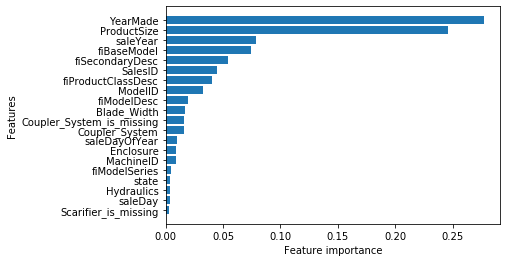

In [313]:
plot_features(X_train.columns, ideal_model.feature_importances_)